# Introduction

This notebook runs PaleoBlockNet v1.0 and produces the reconstruction of JJA blocking over the Last Millennium based on the ensemble-mean NTREND DA reconstruction of surface temperature anomalies. 

Reference publication: Karamperidou, C., Extracting Paleoweather from Paleoclimate: A Deep Learning Reconstruction of Northern Hemisphere Summertime Atmospheric Blocking over the Last Millennium, Nature Communications Earth & Environment, in revision (2024)

## Computational recipe

- Read and preprocess data for input to PaleoBlockNet v1.0
- Load the model 
- Run PaleoBlockNet and produce seasonal (JJA) blocking frequencies 
- Calculate timeseries of blocking in specific sectors: Europe, EuroAtlantic, N. Pacific, N. Hemisphere

- runs with Tensorflow <2.15.0

## Import packages

In [1]:
from datetime import date
today = date.today().strftime('%Y-%m-%d')
print('Last Updated: ' + today) 

Last Updated: 2024-07-02


In [2]:
#Importing required packages
import os
import numpy as np
import xarray as xr

from scipy.stats import skew,stats
import scipy.signal as signal

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
plt.rcParams.update({'figure.max_open_warning': 0})

import zarr
import fsspec
import pandas as pd

import glob as glob
import netCDF4 as nc
from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point

from IPython.display import clear_output
from random import sample 
import pickle as pkl

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import *
tf.config.list_physical_devices(device_type=None)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import scipy.ndimage as ndimage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path

import xesmf as xe

2024-07-02 05:11:55.549065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 05:11:56.355951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
Num GPUs Available:  2


2024-07-02 05:11:57.514784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15371 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2024-07-02 05:11:57.515458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30529 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


2 Physical GPUs, 2 Logical GPUs


In [ ]:
# dynamically change working directory to project_root. 
# NOTE: this works for this file structure; otherwise you need to use file markers  
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# change the current working directory to project_root
os.chdir(project_root)
print("Changed working directory to project root:", os.getcwd())

In [4]:
# Import plotting utilities
from src.visualization import plot_utils

In [5]:
# Define model and data directories
DIR_models=f'{os.getcwd()}/models/'
DIR_data=f'{os.getcwd()}/data/'

# Load model 

In [6]:
# get model from zenodo: https://zenodo.org/records/10739679
model = tf.keras.models.load_model(f'{DIR_models}paleoblocknet_v1.0')

# Input

Here, we use as input MJJA surface air temperature fields spanning the period 750-2011 of the Common Era (CE) from the Last Millennium surface temperature reconstruction by King et al. (2021). This temperature reconstruction is based on assimilating 54 published tree-ring chronologies from the Northern Hemisphere Tree-Ring Network Development (NTREND) network (Wilson et al., 2016, Anchukaitis et al. 2017)  with output from multiple CMIP5 climate models and the CESM Last Millennium Ensemble (LME).  

In [7]:
# get the input dataset from https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=noaa-recon-33632 
input_dataset=xr.open_dataset(f'{DIR_data}external/ensemble-mean-reconstruction.nc').T
# target grid
model_grid=xr.open_dataset(f'{DIR_data}processed/model_grid.nc')
grid_out = xr.Dataset({'lat': (['lat'], model_grid.sel(lat=slice(20,90)).lat.values),
                         'lon': (['lon'], model_grid.sel(lat=slice(20,90)).lon.values),
                        }
                       )

# Pre-process input data

In [8]:
# Regrid
regridder = xe.Regridder(input_dataset, grid_out, 'bilinear',periodic=True)
input_dataset_regridded = regridder(input_dataset)
input_dataset_NH=input_dataset_regridded.sel(lat=slice(30,75))

# Normalize and reshape data 
def preprocess_data(input_dataset):
    # standardize using mean and standard deviation of training dataset.
    # this is specific for PaleoBlockNet v1.0
    input_dataset_z_aux=(input_dataset-0.11600929) / 0.77214915
    input_dataset_z=input_dataset_z_aux.expand_dims({"channel":range(1)}).transpose('time', 'lat', 'lon','channel')
    return input_dataset_z

input_dataset_z=preprocess_data(input_dataset_NH)

# Run PaleoBlockNet

In [9]:
# Predictions 
pred=model.predict(input_dataset_z.data)
pred_xr=input_dataset_z.copy(data=pred)  # turn into xarray

2024-07-02 05:12:01.768696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


40/40 [==============================] - 2s 21ms/step


# Post-process

In [10]:
avg_pred=pred_xr.mean(('time','channel'))*100 # average blocking frequency over the whole Last Millennium, inferred from ensemble-mean temperature anomaly  
avg_pred_plot= plot_utils.add_cyclic_point_to_dataarray(avg_pred) # for plotting

# Plots

## Average map

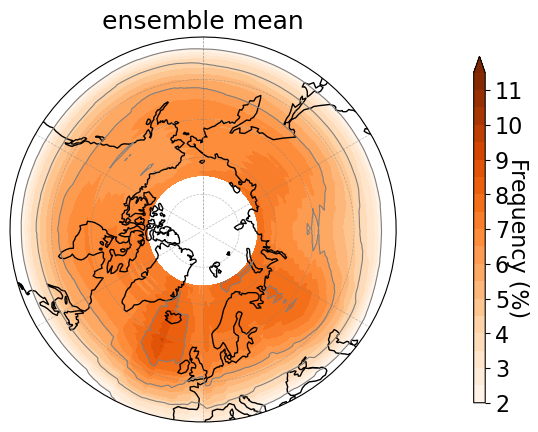

In [11]:
jja_freq_plots = [avg_pred_plot]
titles = ['ensemble mean']
n_plots=len(jja_freq_plots)
n_cols = 1  # Set number of columns per row
n_rows = (n_plots + n_cols - 1) // n_cols

# Create subplots
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20, 5 * n_rows), 
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        squeeze=False)  # Ensures axs is always a 2D array

lat_lims = [40, 90]
legendkw = dict(levels=np.arange(2, 12, 0.5), cmap='Oranges', extend='max', transform=ccrs.PlateCarree())
contourkw = dict(colors='grey', linewidths=0.8, levels=np.arange(2, 12, 2), transform=ccrs.PlateCarree())


for i, ax in enumerate(axs.flatten()):
    plot_utils.polar_set_latlim(lat_lims, ax,ccrs.PlateCarree())
    cf = ax.contourf(jja_freq_plots[i].lon, jja_freq_plots[i].lat, jja_freq_plots[i], **legendkw)
    cs=ax.contour(jja_freq_plots[i].lon, jja_freq_plots[i].lat, jja_freq_plots[i], **contourkw)
    ax.coastlines()
    ax.set_title(titles[i], fontsize=18)
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if i == 0:
        cbar = plt.colorbar(cf, ax=axs, shrink=0.9, orientation='vertical', aspect=30)
        cbar.ax.get_xaxis().labelpad = 20
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_ylabel('Frequency (%)', rotation=-90, size=16)

fig.suptitle('', fontsize=20, x=0.45)
plt.show()

## Time series

In [12]:
window=30
# Euro-Atlantic: 60W-60E 
data_array=pred_xr.copy() 
data_array.coords['lon'] = (data_array.coords['lon'] + 180) % 360 - 180 # shift longitude coordinates from 0-360 to -180-180
data_array = data_array.sortby(data_array.lon)
NTREND_EUATL = data_array.sel(lon=slice(-60, 60)).mean(('lat','lon'))*100 #select the data from 60W to 60E, average, get percentage
NTREND_EUATL_30yr_mean = NTREND_EUATL.rolling(time=window, center=True).mean() # create a rolling window object with a window size of 30 years
NTREND_EUATL_30yr_mean = NTREND_EUATL_30yr_mean.dropna(dim='time') # drop NaN values at the edges due to window size
# N. Pacific 
NTREND_PAC = pred_xr.sel(lon=slice(120, 240)).mean(('lat','lon'))*100 #select the data from 120E to 240E, average, get percentage
NTREND_PAC_30yr_mean = NTREND_PAC.rolling(time=window, center=True).mean()
NTREND_PAC_30yr_mean = NTREND_PAC_30yr_mean.dropna(dim='time')
# Europe 
NTREND_EU = pred_xr.sel(lon=slice(0, 60)).mean(('lat','lon'))*100 #select the data from 0 to 60E, average, get percentage
NTREND_EU_30yr_mean = NTREND_EU.rolling(time=window, center=True).mean()
NTREND_EU_30yr_mean = NTREND_EU_30yr_mean.dropna(dim='time')
# NH 
NTREND_NH = pred_xr.mean(('lat','lon'))*100 # average, get percentage
NTREND_NH_30yr_mean = NTREND_NH.rolling(time=window, center=True).mean()
NTREND_NH_30yr_mean = NTREND_NH_30yr_mean.dropna(dim='time')

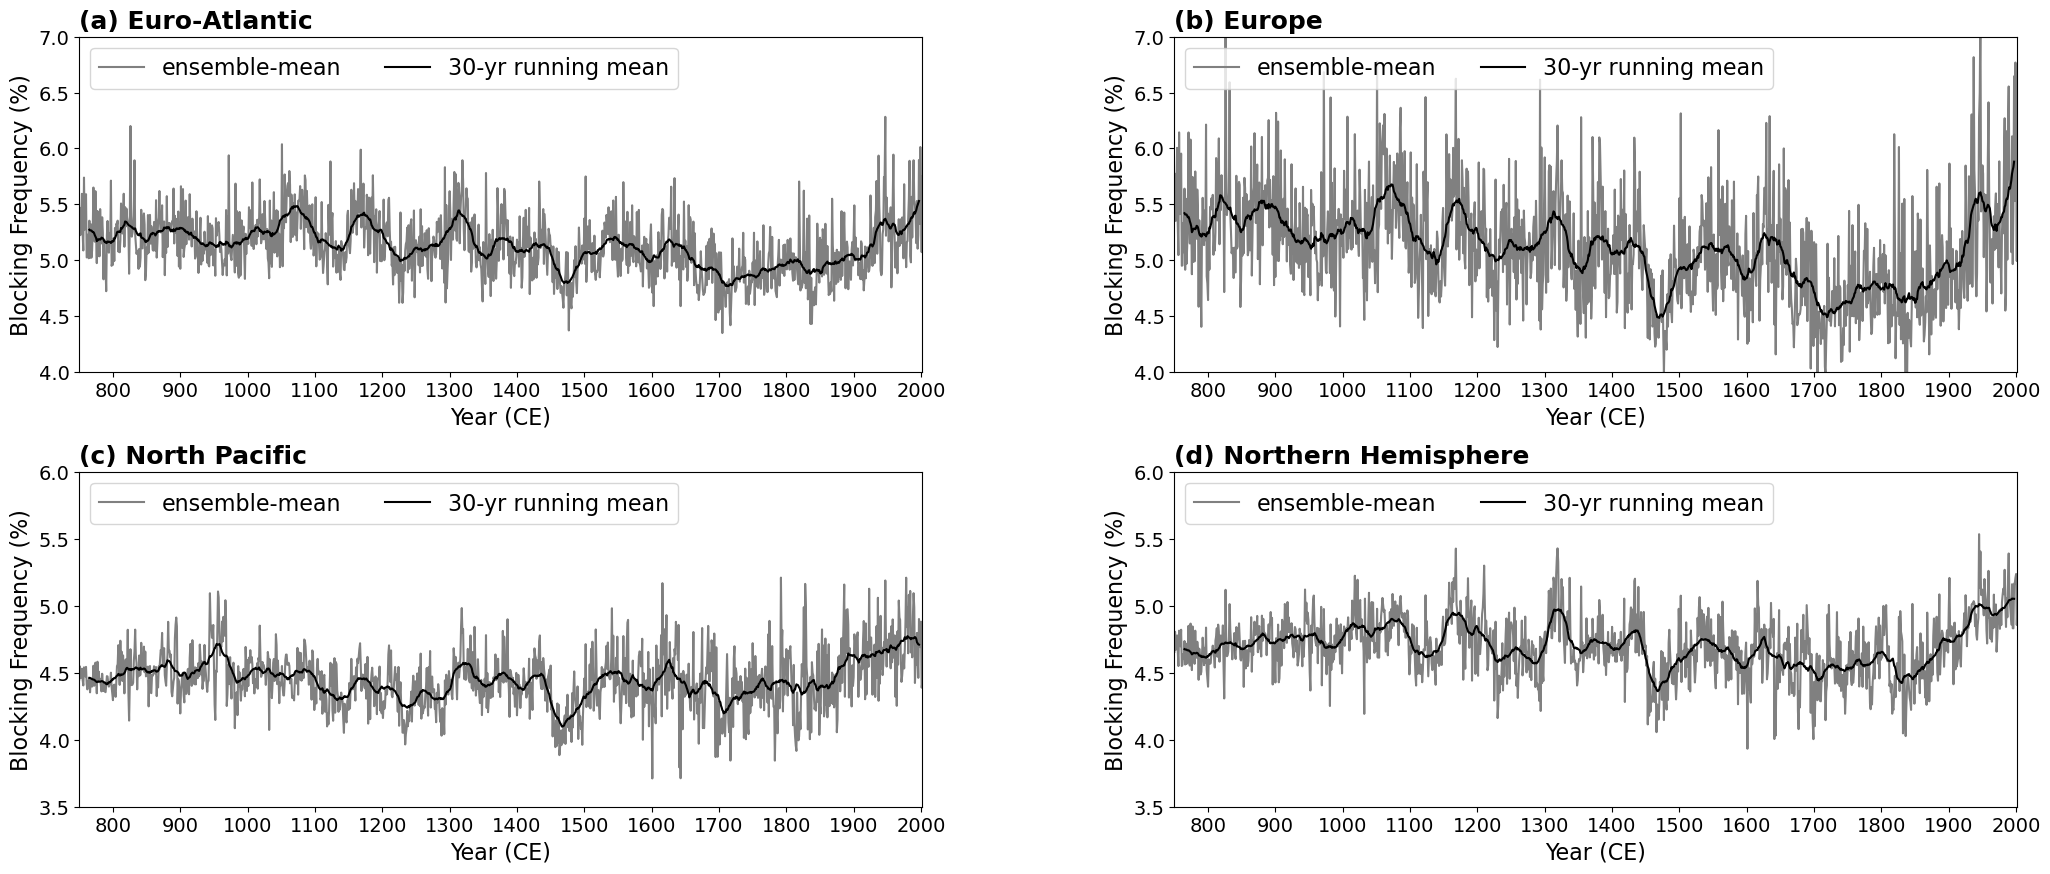

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10))

# Define data for plotting
regions = {
    'Euro-Atlantic': (axs[0, 0], NTREND_EUATL, NTREND_EUATL_30yr_mean ,'(a) Euro-Atlantic', 4, 7),
    'Europe': (axs[0, 1], NTREND_EU, NTREND_EU_30yr_mean ,'(b) Europe', 4, 7),
    'North Pacific': (axs[1, 0], NTREND_PAC,NTREND_PAC_30yr_mean ,'(c) North Pacific', 3.5,6),
    'Northern Hemisphere': (axs[1, 1], NTREND_NH, NTREND_NH_30yr_mean, '(d) Northern Hemisphere', 3.5, 6)
}

# Plot each region
for region, (ax, ntrendmean, runningmean, title, ylim_lower, ylim_upper) in regions.items():
    
    # Plotting data
    mean_line = ax.plot(ntrendmean.time, ntrendmean, color='grey', label='ensemble-mean)', alpha=1)
    runningmean_line = ax.plot(runningmean.time, runningmean, color='black', label='30-yr running mean', alpha=1)

    # Set plot details
    ax.set_xlabel("Year (CE)", fontsize=16)
    ax.set_ylabel("Blocking Frequency (%)", fontsize=16)
    ax.set_title(title, loc='left', fontweight='bold', fontsize=18)
    ax.legend([mean_line[0], runningmean_line[0]], ['ensemble-mean','30-yr running mean'], loc='upper left', ncol=3, fontsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100))
    ax.set_xlim(750, 2001)  # Adjust the x-axis limits
    ax.set_ylim(ylim_lower, ylim_upper)  # Set custom y-axis limits
    ax.tick_params(axis='x', labelsize=14)  # Adjust fontsize for x-axis ticks
    ax.tick_params(axis='y', labelsize=14)  # Adjust fontsize for y-axis ticks

plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()
